In [10]:
! pwd
! pip uninstall sympytorch -y

/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning


Found existing installation: sympytorch 0.1.4
Uninstalling sympytorch-0.1.4:
  Successfully uninstalled sympytorch-0.1.4


In [6]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"
#ROOT="/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))
sys.path.append(os.path.join(ROOT,"DL_models"))

# stable fluids approach

Equation solve by this algorithm is:
$$\frac{\partial \textbf{u}}{\partial t} = -(\textbf{u} \cdot \nabla ) \textbf{u} - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u} + \textbf{f}$$

### The case of this implementation is

$$\frac{\partial \textbf{u}}{\partial t} = -(\textbf{u} \cdot \nabla ) \textbf{u} - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u}$$

In [63]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *
from phi.torch.flow import diffuse, advect, Solve, fluid, math,Field, unstack,stack,batch,field,vec


class physical_model(object):
  # In the case of this solver, domain is not a field, it is a tuples of velocity field and pressure field
  def __init__(self,domain,dt):
    #self.v0=v0
    self.domain=domain
    self.dt=dt
    self.p=None

  def momentum_eq(self,u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.implicit(u,diffusivity, dt=dt,correct_skew=False)
    advection_term = dt * advect.semi_lagrangian(u, u_prev,dt)
    return u + advection_term + diffusion_term


  def implicit_time_step(self, v, dt):
      v=v[0]
      v = math.solve_linear(self.momentum_eq, v, Solve('CG-adaptive',
                                                    1e-2,
                                                    1e-2,x0=v), u_prev=v, dt=-dt)
      v,p = fluid.make_incompressible(v,solve=Solve('CG-adaptive',
                                                    1e-2,
                                                    1e-2,
                                                          #x0=self.p
                                                          ))
      return v,p

  def step(self,v):
    return self.implicit_time_step(v,self.dt)
  

class physical_model(object):
  def __init__(self,domain,dt,advection_solver,projection_solver):
    #self.v0=v0
    self.domain=domain
    self.dt=dt
    self.p=None
    self.advection_solver=advection_solver
    self.projection_solver=projection_solver

  def momentum_eq(self,u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.implicit(u,diffusivity, dt=dt,correct_skew=False)
    advection_term = dt * advect.semi_lagrangian(u, u_prev,dt)
    return u + advection_term + diffusion_term


  def implicit_time_step(self, v, dt):
      v = math.solve_linear(self.momentum_eq, v, self.advection_solver(v), u_prev=v, dt=-dt)
      v,p = fluid.make_incompressible(v,solve=self.projection_solver)
      return v

  def step(self,v):
      return self.implicit_time_step(v,self.dt)
  

geo=UniformGrid(x=60, y=60,bounds=Box(x=1.0, y=1.0))
phi_w=Field( geo,values=vec(x=0.0,y=0.0),
      boundary= {
          'x-': vec(x=0.1,y=0.0),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })

phy=physical_model(
   phi_w,0.01,
   advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
   projection_solver=Solve('CG-adaptive',1e-3,1e-3)
)

# Multi resolution adaptation

In [188]:
from random import choice
from einops import rearrange
from Differentiable_simulation import Space2Tensor,Tensor2Space
from phi.torch.flow import *

def Tensor2Space(Tensor,geometry,tensor_signature='c x y->x y c',space_signature="x:s,y:s,vector:c"):
  #return math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x:s,y:s,vector:c")
  return Field(geometry=geometry,values=math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x:s,y:s,vector:c"))

class SOL_trainer(object):
    def __init__(self,boundary,model,optimizer,simulation_steps,spatial_step,time_step,coarse_to_fine_timefactor=1/4,co2gt_spatial_factor=4):
      self.boundary = boundary
      self.co2gt_spatial_factor=co2gt_spatial_factor
      self.spatial_step=spatial_step
      self.co2gt_time_factor=coarse_to_fine_timefactor
      self.co_dt=time_step
      self.gt_dt=self.co_dt*self.co2gt_time_factor

      self.geo_co=UniformGrid(x=self.spatial_step, y=self.spatial_step,bounds=Box(x=10.0,y=10.0))
      self.geo_gt=UniformGrid(x=self.spatial_step*self.co2gt_spatial_factor, y=self.spatial_step*self.co2gt_spatial_factor,bounds=Box(x=10.0,y=10.0))
      self.v_co=Field(self.geo_co,values=vec(x=tensor(0.0),y=tensor(0.0)),boundary=self.boundary) # add initial conditions
      self.v_gt=Field(self.geo_gt,values=vec(x=tensor(0.0),y=tensor(0.0)),boundary=self.boundary) # add initial conditions

      self.ph_model_co=physical_model(self.v_co,dt=self.co_dt,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-2,1e-2,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-2,1e-2))
      self.ph_model_gt=physical_model(self.v_gt,dt=self.gt_dt,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-4,1e-4)
                                      )

      self.init_states_gt=[self.v_gt]
      for i in range(50):
        self.init_states_gt.append(self.ph_model_gt.step(self.init_states_gt[-1]))

      self.n_steps=simulation_steps
      self.st_model=model

      self.loss=(lambda y_,y: torch.sum((y-y_)**2)/self.n_steps)

      self.optimizer=optimizer

      self.alpha=1

    def forward_prediction_correction(self):
      #print(f"prediction correction simulation")

      states_pred=[self.v_co]
      states_corr=[Tensor2Space(1e-3*self.st_model(Space2Tensor(self.v_co,self.geo_co)),self.geo_co)]

      states_pred=[self.v_co+states_corr[-1]]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in range(self.n_steps):

        # Step last in states_pred
        states_pred.append(self.ph_model_co.step(states_pred[-1]))
        # Correct with model of last states_pred
        states_corr.append(Tensor2Space(1e-3*self.st_model(Space2Tensor(states_pred[-1],self.geo_co)),self.geo_co))
        # Sum correction to last in states pred
        states_pred[-1]=states_pred[-1]+states_corr[-1]

      states_pred=list(map(lambda corr:Space2Tensor(corr,self.geo_gt),states_pred))

      return states_pred,states_corr

    def forward_fine_grained(self):
      states_gt=[Space2Tensor(self.v_gt,self.geo_gt)]

      #print(f"fine grained simulation")
      for i in range(int(self.n_steps/self.co2gt_time_factor)):
        ##print(f"fine grained step {i}")
        self.v_gt=self.ph_model_gt.step(self.v_gt)
        if i%int(1/self.co2gt_time_factor)==0:
          states_gt.append(Space2Tensor(self.v_gt,self.geo_gt))
      return states_gt

    def train(self,epochs):
      losses=[]
      for i in range(epochs):
        #print(f"epoch {i}")
        gt_batch=[]
        co_batch=[]
        for b in range(5):
          print(f"making batch {b}")
          self.v_gt=choice(self.init_states_gt)
          states_gt=self.forward_fine_grained()
          self.v_co=Field(values=Tensor2Space(states_gt[0].detach(),self.geo_co),geometry=self.geo_co,boundary=self.boundary)
          print(f"last roll initial state")
          #plot(Field(values=Tensor2Space(states_gt[0],self.geo_co),geometry=self.geo_co,boundary=self.boundary))
          #plot(self.v_co)
          #plt.show()
          states_pred,states_corr=self.forward_prediction_correction()
          gt_batch=gt_batch+states_gt
          co_batch=co_batch+states_pred

        print("training batch")
        states_pred=torch.concat(states_pred,axis=0)
        states_gt=torch.concat(states_gt,axis=0)
        loss=self.loss(states_pred,states_gt)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        losses.append(loss.cpu().detach().numpy())
      return losses

      def test(self,epochs):
        losses=[]
        for i in range(epochs):
          #self.alpha=self.alpha*(i/epochs)
          states_pred,states_corr=self.forward_prediction_correction()
          states_gt=self.forward_fine_grained()

          states_pred=torch.concat(states_pred,axis=0)
          states_gt=torch.concat(states_gt,axis=0)
          loss=self.loss(states_pred,states_gt)

          losses.append(loss.cpu().detach().numpy())
        return losses


In [193]:
from DL_models.Models.CNN_models import simple_cnn_model

boundary = {'x-': vec(x=0.5,y=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0
            }

model=simple_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
T=SOL_trainer(boundary,model,optimizer,
              simulation_steps=2,spatial_step=64,time_step=0.1,coarse_to_fine_timefactor=1/4,co2gt_spatial_factor=1)

In [194]:
ll=[]

making batch 0
last roll initial state
making batch 1
last roll initial state
making batch 2
last roll initial state
making batch 3
last roll initial state
making batch 4
last roll initial state
training batch


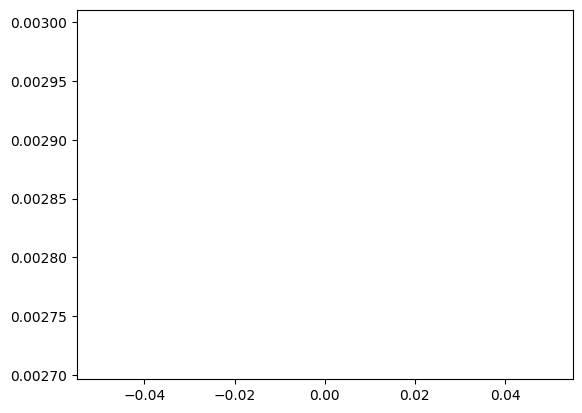

making batch 0
last roll initial state
making batch 1
last roll initial state
making batch 2
last roll initial state
making batch 3
last roll initial state
making batch 4
last roll initial state
training batch


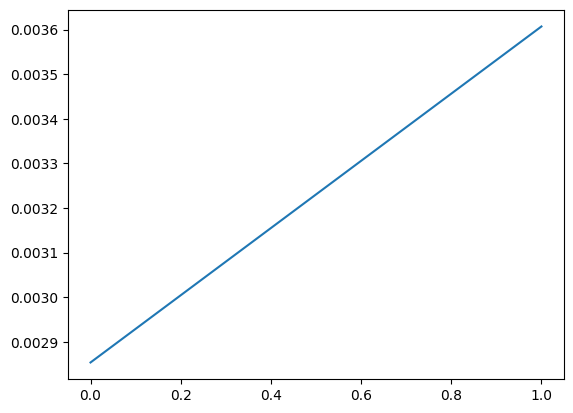

making batch 0
last roll initial state
making batch 1
last roll initial state
making batch 2
last roll initial state
making batch 3
last roll initial state
making batch 4
last roll initial state
training batch


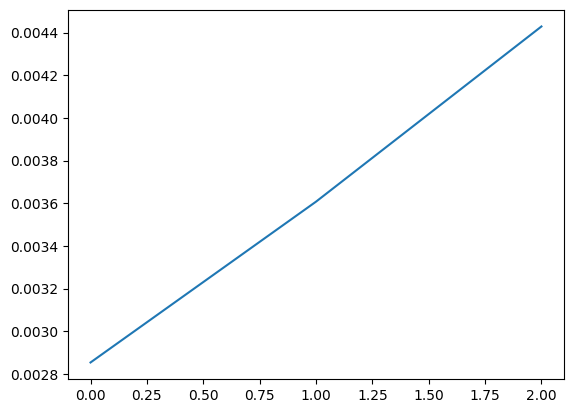

making batch 0
last roll initial state
making batch 1
last roll initial state
making batch 2
last roll initial state
making batch 3
last roll initial state
making batch 4
last roll initial state
training batch


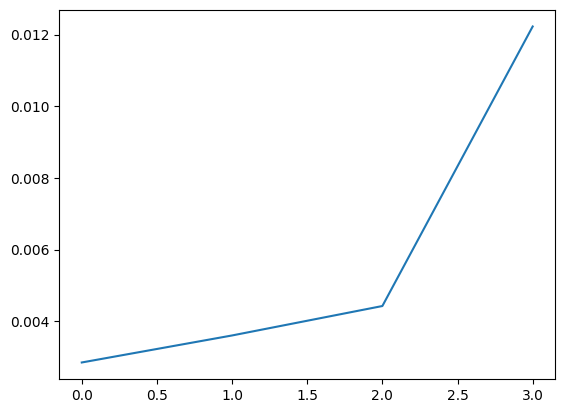

making batch 0
last roll initial state
making batch 1
last roll initial state
making batch 2
last roll initial state
making batch 3
last roll initial state
making batch 4
last roll initial state
training batch


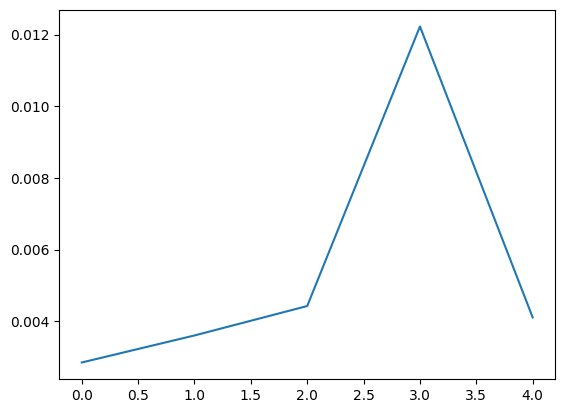

making batch 0
last roll initial state
making batch 1
last roll initial state
making batch 2
last roll initial state
making batch 3
last roll initial state
making batch 4
last roll initial state
training batch


Diverged: Solve diverged within 162 iterations using Φ-ML CG (PyTorch*)

In [195]:
import matplotlib.pyplot as plt
for i in range(50):
  l=T.train(1)
  ll=ll+l
  plt.plot(ll)
  plt.show()

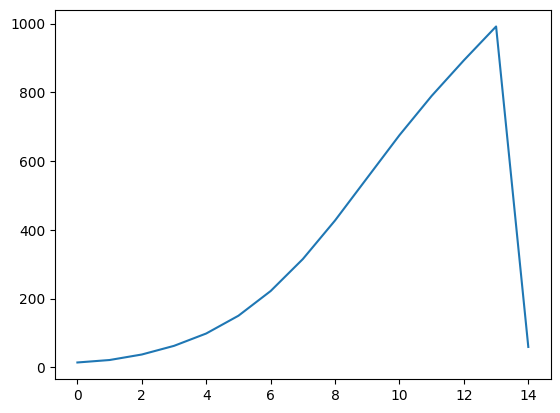

In [116]:
plt.plot(ll)

# PINNS BASED

## 2D

In [3]:
class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(2, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 2, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*1
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x[0]

In [12]:
boundary = {'x-': vec(x=1.0,y=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0
            }
boundary
geo=UniformGrid(x=128, y=128,bounds=Box(x=100, y=100))
v0=Field(geo,values=vec(x=tensor(0.0),y=tensor(0.0)),boundary=boundary)

phys=physical_model(v0,dt=0.1,
                    #advection_solver=(lambda v: Solve('CG-adaptive',1e-2,1e-2,x0=v)),projection_solver=Solve('CG-adaptive',1e-2,1e-2)
                    )

#from DL_models.Models.CNN_models import simple_cnn_model

model=simple_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

In [17]:
v,p = fluid.make_incompressible(v0,solve=Solve('CG-adaptive',1e-2,1e-2))

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


In [24]:
import matplotlib.pyplot as plt


(xˢ=128, yˢ=128) 49.839 ± 28.787 (1e-05...1e+02)

In [13]:
phys.step(v0)



Field[(xˢ=128, yˢ=128, vectorᶜ=x,y)]

In [14]:
from Train_differentiable_physics import PINNS_based_SOL_trainer
import torch
T=PINNS_based_SOL_trainer(
    field=(v0,fluid.make_incompressible(v0,solve=Solve('CG-adaptive',1e-2,1e-2))[-1]),
    model=model,
    optimizer=optimizer,
    simulation_steps=2,
    time_step=0.1,
    loss=torch.mean
    )

In [16]:
from random import randint
randint()

TypeError: Random.randint() missing 2 required positional arguments: 'a' and 'b'

In [15]:
T.train(5)

[array(0.5626921, dtype=float32),
 array(-0.45075464, dtype=float32),
 array(-0.6038111, dtype=float32),
 array(-0.64447063, dtype=float32),
 array(-0.6510437, dtype=float32)]

## 3D

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


Diverged: Solve diverged within 819 iterations using Φ-ML CG (PyTorch*)

In [124]:
boundary = {'x-': vec(x=1.0,y=0.0,z=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0,
            'z-':0,
            'z+':0
            }
boundary
geo=UniformGrid(x=128, y=128,z=128,bounds=Box(x=50, y=50,z=50))
v0=Field(geo,values=vec(x=tensor(0.0),y=tensor(0.0),z=tensor(0.0)),boundary=boundary)

phys=physical_model(v0,dt=0.1,
                    #advection_solver=(lambda v: Solve('CG-adaptive',1e-2,1e-2,x0=v)),projection_solver=Solve('CG-adaptive',1e-2,1e-2)
                    )

In [125]:
phys.step(v0)

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


Field[(xˢ=128, yˢ=128, zˢ=128, vectorᶜ=x,y,z)]

In [130]:
v0.geometry

(xˢ=128, yˢ=128), bounds=Box(x=(0, 50), y=(0, 50))